- [introduction](#introduction)
- [assumptions](#assumptions)
- [methodology](#methodology)
- [implementation](#implementation)
  - [data](#data)
  - [results](#results)
- [appendix](#appendix)
  - [walkthrough](#walkthrough)

# introduction
On February 24th 04:06 UTC+1, the "special military operation" was announced by the Russian president and the Russian army invaded Ukraine. In the run-up to the event, there had been warnings by US officials about the possibility of this outcome. Was the invasion expected by the FX market &mdash; a known barometer of a country's economic well-being? Did the warnings reinforce the expectation?

To answer these questions, I take note that the annonuncement was followed by a depreciation of RUB to the level of about 85 RUB per 1 USD; i assume that the market participants had anticipated this level for the exchange rate in the case of an invasion, equate the probability of an invasion to the probability of USDRUB=85, and use currency options to estimate the probability of this development.

I find that the probability of an invasion was fluctuating at 5-15% in the week before 02/24 and jumped to 25% in the hours immediately before the announcement:

<img src="./output/figures/prob-nonparam-thresh85.png" alt="probability of invasion getting higher on feb 23rd" width="600"/>

# assumptions
In the immediate run-up to the invasion (a week or so):
1. the FX market participants expected RUB to fall to the level of 85 RUB per 1 USD in case of an invasion;
1. USDRUB dynamics was strongly determined by expectations of an invasion and by little else;
2. changes in the risk-neutral probability coincided with changes in the physical probability (risk premium was constant);
3. the risk-neutral distribution did not have tails that could not be approximated by those of a spherical distribution;
4. markets were sufficiently liquid, and Bloomberg quotes are representative.

While assumptions 1-3 are alright: the time span of a week is short and the conflict was arguably the major driver of related asset prices &mdash; assumption 4 is already prohibitively strong and compromises the very idea of estimating the probability of a tail risk event; assumption 5 is alright.

# methodology

To estimate the probability of the spot rate exceeding a certain threshold, I integrate the risk-neutral density of the spot rate extracted non-parametrically over a suitable domain.

The well-known result from [Breeden and Litzenberger (1978)](https://www.jstor.org/stable/2352653?seq=1#metadata_info_tab_contents) equates the risk-neutral density of the underlying $q(S)$ to the second derivative of the option pricing function $C(\cdot)$ w.r.t. the strike price $K$:
$$q(S) = e^{r_f \tau} \frac{\partial^2 C(S,K,\ldots)}{\partial K^2}.$$
With a pricing function at hand, numerical calculation of the density is straighforward. Here, I take $C$ to be the Black-Scholes pricing function at the level of SABR-derived implied volatilities along the strike dimension:
$$C(S, K), \ldots = C^{bs}(S, \hat{\sigma}(K), K, \ldots),$$
where $\hat{\sigma}(K)$ is the SABR volatility smile calibrated to the FX option contracts (details in the [data section](#data)).

The risk-neutral probabilities are of course different from the physical ones: had the market participants been asked directly about the probability of war, the answer would be different from what the asset prices tell, just as the insurance premium-based probability of a hurricane is different from the physical (or 'objective') probability, the difference stemming from the fact that people undervalue assets that pay off poorly in the states of high marginal utility. I would imagine that the RUB investors' marginal utility, also called a measure of hunger, negatively correlates with the the USDRUB spot returns just because everyone is worse off in a war; hence, the risk-neutral probability that I estimate below arguably overestimates the physical one.

# implementation

## imports

In [1]:
# pip/conda
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.dates import DateFormatter, DayLocator, HourLocator  # plotting
import warnings  # suppress warnings

# local
from optools.blackscholes import option_price as bs_price

# project
from src.setup import *
from src.datafeed_.downstream import *
from src.visuals import *

## settings

In [2]:
# parameters
TAU = 1/12  # maturity of options

# matplotlib
palette = plt.rcParams['axes.prop_cycle'].by_key()['color']

# formatting frames
def format_dataframe(df_: pd.DataFrame, tail=True):
    """A little formatter helper."""
    if tail:
        return format_dataframe(df_.tail(), tail=False)
    
    if df_.index.inferred_type == 'datetime64':
        return format_dataframe(df_.rename_axis(index="date").reset_index(),
                                tail=tail)
    
    res_ = df_\
        .style.format(formatter={"date": lambda x: x.strftime("%Y-%m-%d %H:%M")},
                      precision=2)\
        .hide(axis=0)
    return res_

# suppress warnings
warnings.filterwarnings('ignore')

## data

### events

Events and their timestamps (GMT+1) are from Bloomberg.

In [3]:
# load events data
d_events = get_timeline()
dt_t = d_events.index[0]

format_dataframe(d_events, tail=False)

date,event
2022-02-24 04:06,putin announces special military operation
2022-02-18 22:58,biden warns russia planning attack in coming days
2022-02-17 15:19,biden estimate prob of invasion as very high
2022-02-11 20:03,jake sullivan believes putin has decided to invade next week
2022-02-11 11:34,blinken warns russia can attack during the olympics


### spot
Spot quotes of USDRUB at 1-min frequency (GMT+1 time) are from Bloomberg.

In [4]:
# load spot data
d_spot = get_spot_data()

format_dataframe(d_spot.set_index("date"), tail=True)

date,spot
2022-02-28 16:46,109.50
2022-02-28 16:47,109.61
2022-02-28 16:48,109.54
2022-02-28 16:49,107.90
2022-02-28 16:50,107.82


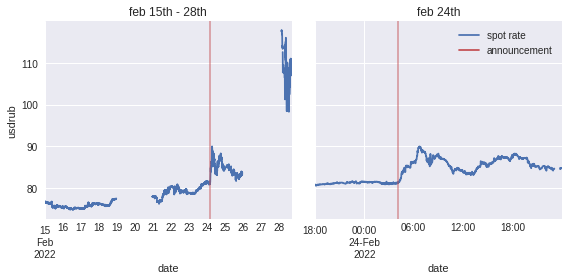

In [5]:
# plot spot exchange rate dynamics
plot_spot(d_spot.set_index("date").squeeze())
plt.show()

### forward
1-month forward quotes are from Bloomberg:

In [6]:
# load forward data
d_forward = get_forward_data()

format_dataframe(d_forward, tail=True)

date,forward
2022-02-28 16:46,112.64
2022-02-28 16:47,112.75
2022-02-28 16:48,112.69
2022-02-28 16:49,111.01
2022-02-28 16:50,110.92


### rates
USD rates are 1-month OIS rates; RUB rates are implied from the covered interest rate parity for USDRUB:
$$ F = S \times \frac{1 + r_{rub}}{1 + r_{usd}} $$

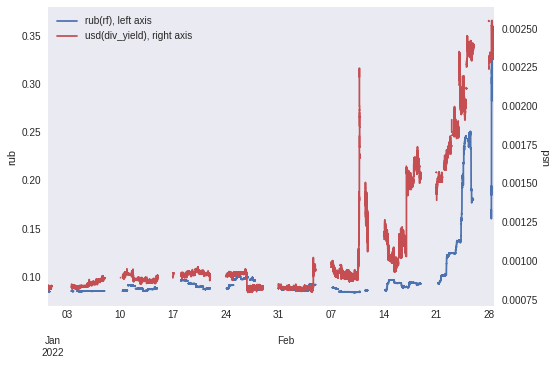

In [7]:
# interest rates data: 'rf' for the RUB rate, 'div_yield' for the USD rate.
d_rates = get_rates_data()
plot_rates(d_rates.set_index("date"))
plt.show()

### option contracts

FX options are quoted in terms of implied volatilities (henceforth "IV") of "at-the-money" contracts, as well as 10- and 25-delta "butterfly spreads" (aka "market strangles") and "risk reversals". The exact definitions of these differ between currency pairs, and I refer the reader to the excellent book ["Foreign Exchange Option Pricing: A Practitioner's Guide"](https://books.google.ch/books?id=7vua-0-2sgMC&redir_esc=y) by Iain Clark for further details. In what follows, `v_atm` references the at-the-money IV, `v_10b` (`v_25b`) &mdash; the IV of the 10-delta (25-delta) market strangle and `v_10r` (`v_25r`) &mdash; the IV of the 10-delta (25-delta) risk reversal.

In [8]:
# option contracts data
d_opt = get_option_contracts_data()

format_dataframe(d_opt.sort_values("date"), tail=True)

date,name,value
2022-02-28 16:44,v_10r,0.46
2022-02-28 16:44,v_25r,0.21
2022-02-28 16:44,v_atm,0.85
2022-02-28 16:44,v_25b,0.04
2022-02-28 16:44,v_10b,0.15


## estimating probability of invasion <a name="results"></a>

I present only the results of the calculations here. A detailed walkthrough is postponed to the [appendix](#walkthrough).

In [10]:
# non-parametric density, integrated from different levels upwards
fname = "output/estimates/prob-nonparam.csv"
prob_np = pd.read_csv(fname, index_col=0, parse_dates=True)\
    .rename(columns=int)

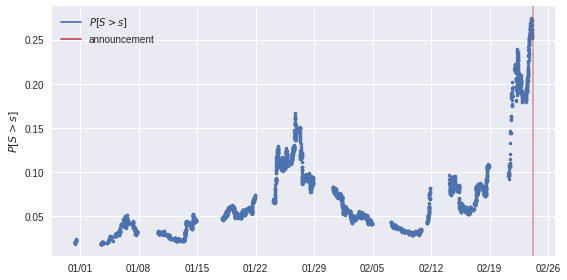

In [11]:
# P[S > 85]
thresh = 85
plot_invasion_probability(prob_np.loc[:dt_t, thresh], show_invasion=True)
plt.show()

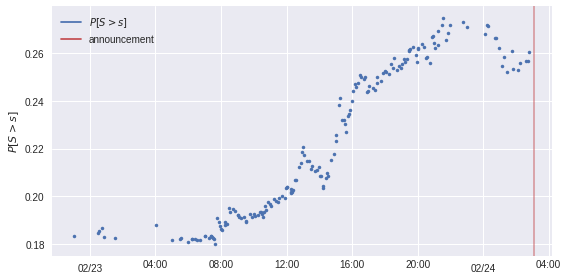

In [12]:
plot_invasion_probability_zoomed(prob_np.loc[:dt_t, thresh])
plt.show()

The probability of invasion is thus estimated at a level of 5-10% in the week leading to Putin's announcement, suddenly jumping to 25% in the day before it and remaining at that level until the news were broken.

Next, I check how this probability changed in response to the forebodings of US officials. In total, there were 4 of them, as listed in the [data section](#events).

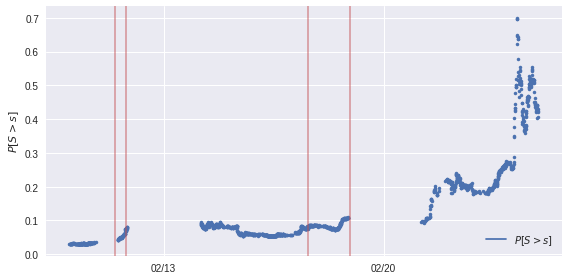

In [14]:
fig = plot_invasion_probability(prob_np.loc["2022-02-10":"2022-02-24", thresh], show_invasion=False)
for dt_, _ in d_events.iloc[1:].iterrows():
    fig.gca().axvline(x=dt_, color=palette[2], alpha=0.5)
plt.show()

# appendix

## walkthrough: <a name="walkthrough"></a>

In what follows I will walk an interested reader through the calculations. First, let's load the data, merge everything and select one datetime &mdash; the one right before the announcement.

In [4]:
# data
d_option = get_option_contracts_data()
d_forward = get_forward_data()
d_spot = get_spot_data()
d_rates = get_rates_data()

# pivot, merge to have all necessary values for each date ready
data = pd.concat(
    (d_option.pivot("date", "name", "value"),
     d_spot.set_index("date"),
     d_forward.set_index("date"), 
     d_rates.set_index("date")),
    axis=1
)
data = data.dropna()

# select one little chunk
chunk = data.iloc[[1500]]

format_dataframe(chunk)

date,v_10b,v_10r,v_25b,v_25r,v_atm,spot,forward,div_yield,rf
2022-01-21 02:45,0.04,0.13,0.01,0.06,0.18,76.89,77.45,0.00,0.09


These values are sufficient to estimate the risk-neutral density. For that, as mentioned in the main part, the option pricing function is needed. I define it to be, for any strike $K$, the Black-Scholes formula evaluated at the fitted implied volatility at that level of $K$; the volatility itself is a function of $K$, specifically, the fitted value of a SABR smile calibrated to the observed quotes of option contracts: 
$$C(S, K), \ldots = C^{bs}(S, \hat{\sigma}(K), K, \ldots).$$
The calibration process is tricky, as described in ch. 3.7.1 of [Clark (2011)](https://books.google.ch/books?id=7vua-0-2sgMC&redir_esc=y). Conventions such as at-the-money definition are taken from Bloomberg.

One thing to note is that the span of strike prices (implicitly) covered by the contracts is usually very narrow and does not extend into the interesting tail regions; this is yet another reason to take the estimates with a grain of salt.

Anyway, let's calibrate the SABR model to the chunk of data above:

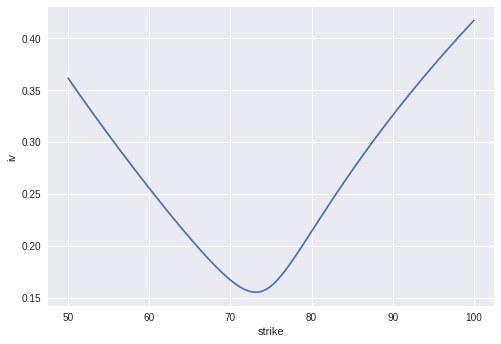

In [5]:
from optools.volsmile import SABR

# make Series for easier indexing
chunk = chunk.T.squeeze()

# fit
sabr = SABR.fit_to_fx(
    tau=TAU,
    v_atm=chunk["v_atm"],
    contracts={0.1: {"ms": chunk["v_10b"],
                     "rr": chunk["v_10r"]},
               0.25: {"ms": chunk["v_25b"],
                      "rr": chunk["v_25r"]}},
    delta_conventions={"atm_def": "dns",
                       "is_premiumadj": True,
                       "is_forward": False},
    **chunk[["spot", "forward", "rf", "div_yield"]]
)

# plot
fig, ax = sabr.plot(domain=np.arange(50, 100, 1e-04))
ax.set_xlabel("strike")
ax.set_ylabel("iv")
plt.show()

`sabr` object above is a callable that computes the IV for a given $K$. Now, it is possible to define the option pricing function $C^{bs}(S, \hat{\sigma}(K), K, \ldots)$ as a function of $K$ only:

In [6]:
from optools.blackscholes import option_price as bs_price

sigma_hat = sabr  # enters the function below

def call_pricer(x_):
    """Get price of call option at a given strike.
    
    NB: takes global variable `data` defined above as input!
    """
    rf = data["rf"].iloc[0]
    
    # these are the same for any iloc in `data`
    forward = data["forward"].iloc[0]
    div_yield = data["div_yield"].iloc[0]
    rf = data["rf"].iloc[0]
    
    f = bs_price(strike=x_, vola=sigma_hat(x_), forward=forward,
                 div_yield=div_yield, rf=rf,
                 tau=TAU, is_call=True)
    
    return f

# example
print(call_pricer(np.array([80, 90, 100.0])))

[0.42714335 0.08884317 0.03326312]


This function can be differentiated twice to arrive at the density. Below, I define a function to return the density at point `s`:

In [7]:
from scipy.misc import derivative

def density_estimator(s):
    """Get density at point `s`.
    
    Evaluates the second-order derivative of `call_pricer`.
    
    NB: takes global variables `call_pricer` and `data` defined above as input!
    
    """
    res = derivative(call_pricer, s, dx=1e-04, n=2) \
        * np.exp(chunk["rf"] * TAU)
    
    return res

# example
print(np.round(density_estimator(85.0), 4))

0.0056


Finally, to arrive at the probability of the spot rate exceeding a threshold, e.g. 85, at options' expiration, I integrate the density from this threshold to ~infinity~ a large value:

In [8]:
from scipy.integrate import simps

# domain of integration (step size of 1e-04)
thresh = 85.0
x = np.arange(thresh, 200, 1e-04)

# integrate
prob = simps(density_estimator(x), x)
print(np.round(prob, 4))

0.0266
